In [ ]:
# 구글 드라이브의 폴더와 구글 코랩 폴더 연결
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 현재 경로 확인
!pwd

/content/drive/My Drive/Colab Notebooks


In [ ]:
# drive/My Drive/Colab Notebooks 경로로 변경
%cd drive/My\ Drive/Colab\ Notebooks\

[Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks'
/content/drive/My Drive/Colab Notebooks


# Segmentation

```
이미지에서 점 단위로 예측하는 기법

확인해야 할 포인트
1. 어떻게 한점 한점을 예측할지 
2. 원본의 크기와 같아야 한다 
- 입력된 이미지를 넣었을 때 원본과 같은 크기로 나와야 한다 

종류 

1. Semantic segmentation
- 이미지 내에 있는 물체들을 의미 있는 단위로 분할한다 
- 이미지의 각 픽셀이 어느 클래스에 속하는지 예측한다 
- 동일한 객체들끼리는 한 번에 Masking을 수행한다
- 대표적으로 FCN이 있다
2. Instance segmentation
- 동일한 객체들이여도 개별 Object로 간주하고 Masking을 수행한다 
- 대표적으로 Mask R-CNN이 있다 
```

## FCN(Fully Convolutional Networks)

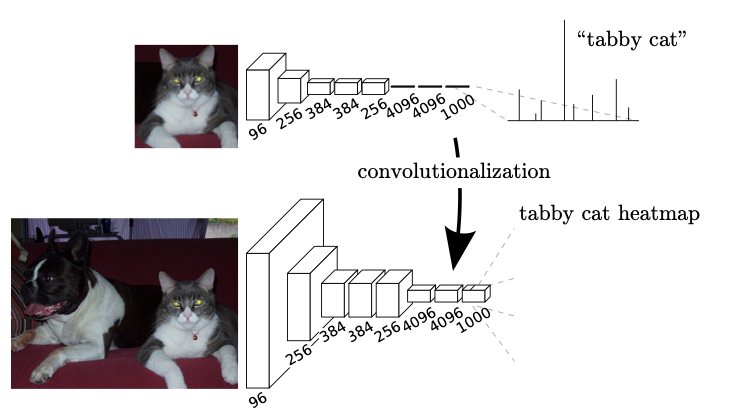

> AlexNet의 구조에서 Dense layer 부분을 Convolution layer로 변형한 모델 (convolutionalization)

```
Semantic segmentation을 하기 위해서는 AlexNet 구조에서 FC layer를 변형 해야 하는 이유가 있다 

1. FC layer를 사용하면 이미지의 위치 정보가 사라진다 
2. FC layer를 사용하면 입력 이미지의 크기가 고정된다 

따라서 semantic segmenation을 하기 위해서 마지막 FC layer를 convolution layer로 
변형 함으로써 위치 정보를 보존하고 이미지 크기로 부터 유연할 수 있다 
```

## Skip combining

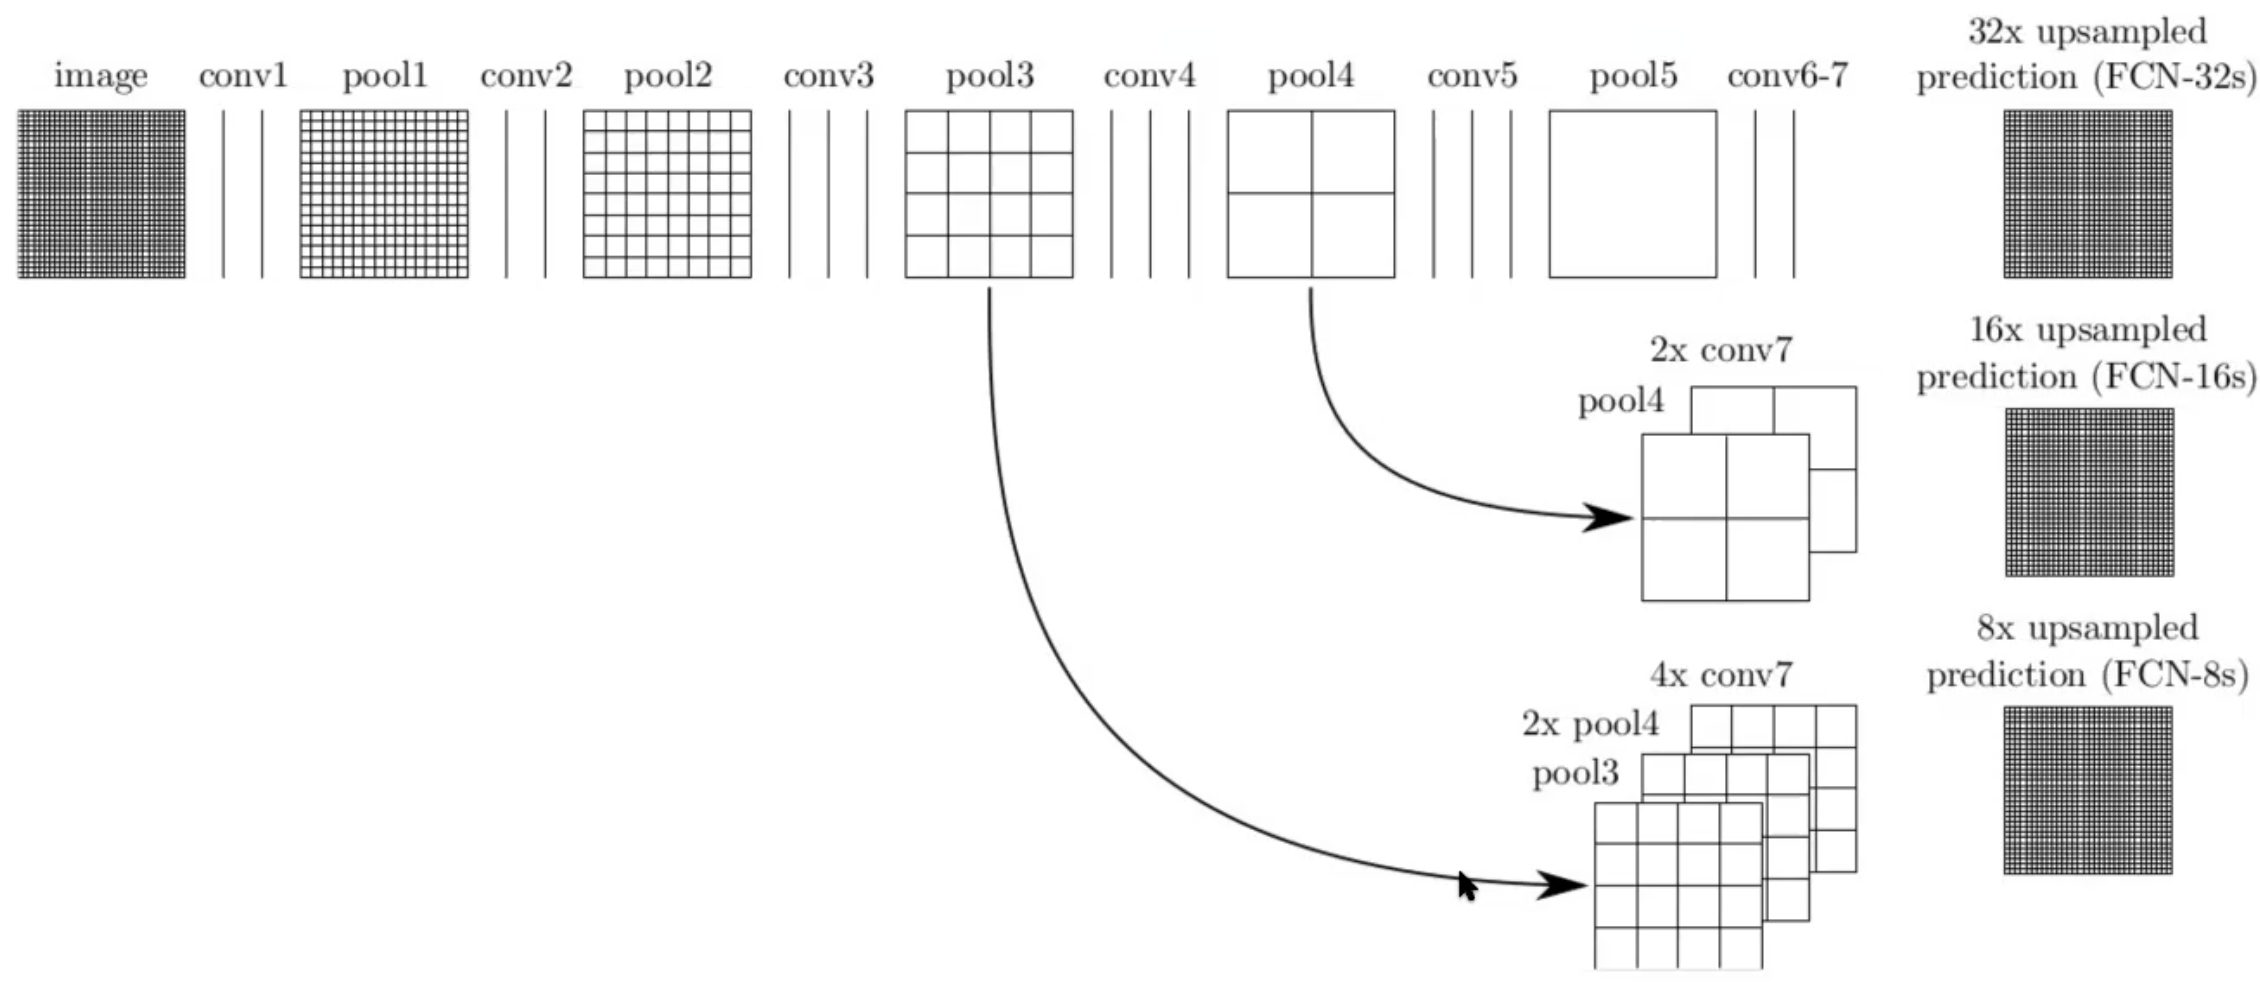

```
이전의 정보를 더함으로써 복원할때 활용한다 
이전의 layer는 현재의 layer가 가지는 정보보다 디테일한 정보를 가지고 있기 때문에 복원하는데 도움이 되기 때문이다
```

## U-net

> Instance segmentation 방법

### U-net 구조 

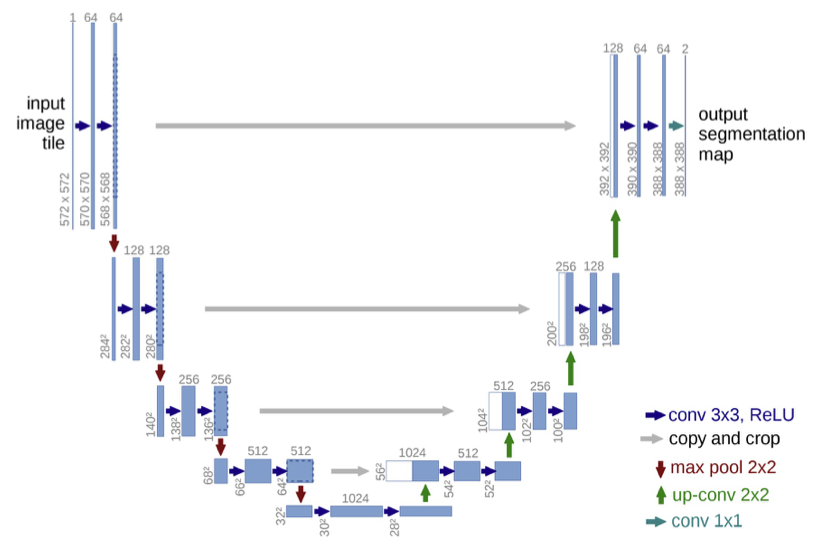

```
U-Net은 이미지의 전반적인 컨텍스트 정보를 얻기 위한 네트워크와 정확한 지역화(Localization)를 위한 네트워크가 대칭 형태로 구성되어 있다
```

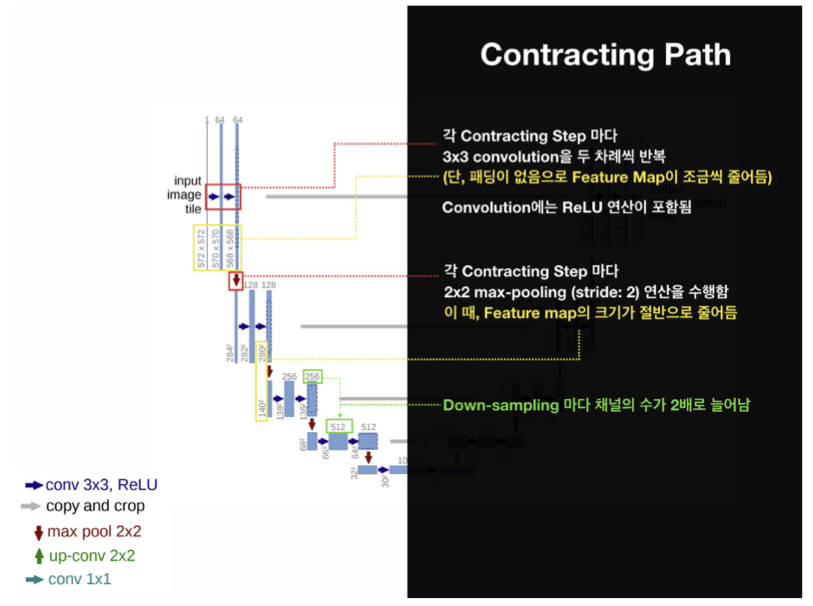

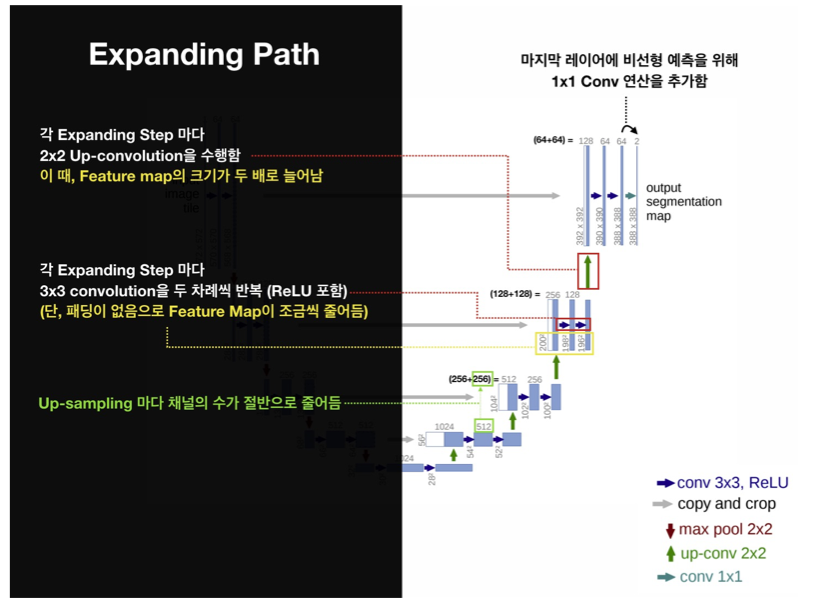

```
Contracting path의 최종 feature map으로 부터 높은 해상도의 결과를 얻기 위해 upsampling을 진행한다 
coarse map -> dense prediction
```

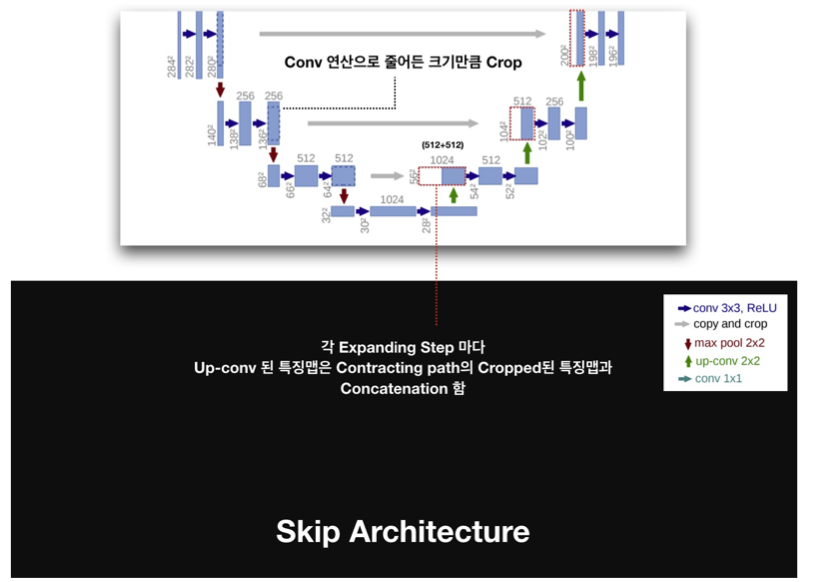

## Overlap-Tile Input

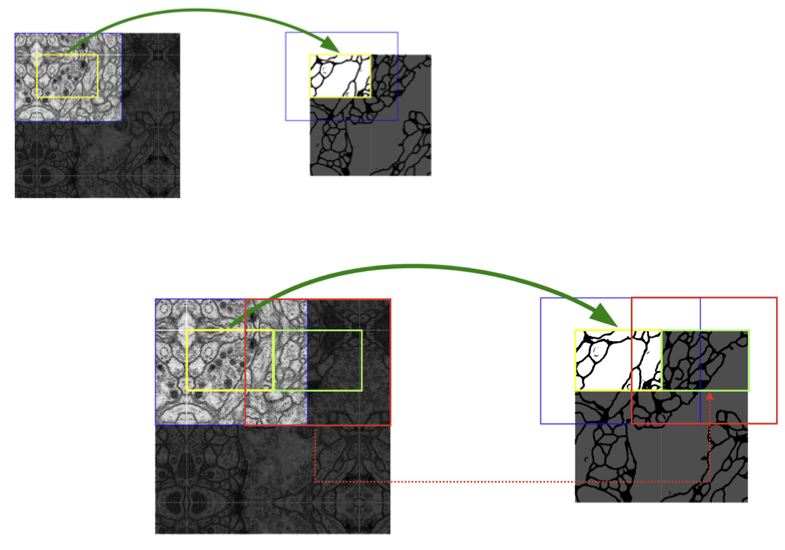

```
이미지를 타일로 나누어서 입력으로 사용한다
파란 영역의 이미지를 입력하면 노란 영역의 segmentation 결과를 얻는다 

다음 tile에 대한 segmentation을 얻기 위해서는 이전 입력의 일부분이 포함되어 있어야 한다 
```

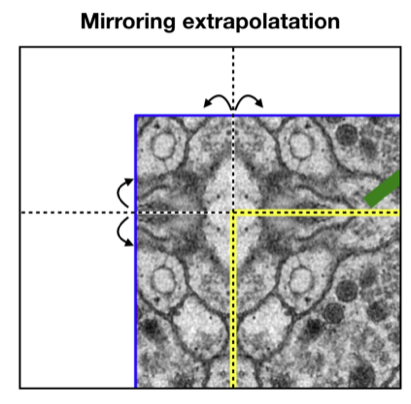

```
이미지의 경계 부분 픽셀에 대한 segmentation을 위해 0이나 임의의 패딩값을 사용하는 대신 
이미지 경계 부분의 미러링을 이용한 Extrapolation 기법을 사용한다 
```

## U-net 구현하기

In [1]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True) # 37마리 애완동물 6000장 이미지 

Metal device set to: Apple M1


2021-11-02 22:32:13.649100: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-02 22:32:13.649180: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
dataset['train'] # cpu, gpu 둘다 활용하여 효율적 연산 가능한 데이터 구조 

<PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>

In [4]:
dataset['test']

<PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>

In [5]:
for i in dataset['train'].take(1):
    image = i['image']
    mask = i['segmentation_mask']

2021-11-02 22:32:13.725399: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-02 22:32:13.727097: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


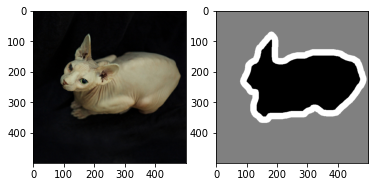

In [6]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(image)
ax[1].imshow(mask, cmap='gray')

In [7]:
backbone = tf.keras.applications.MobileNetV2(input_shape=(128,128,3), include_top=False)

In [8]:
backbone.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [9]:
from tensorflow.keras.utils import plot_model

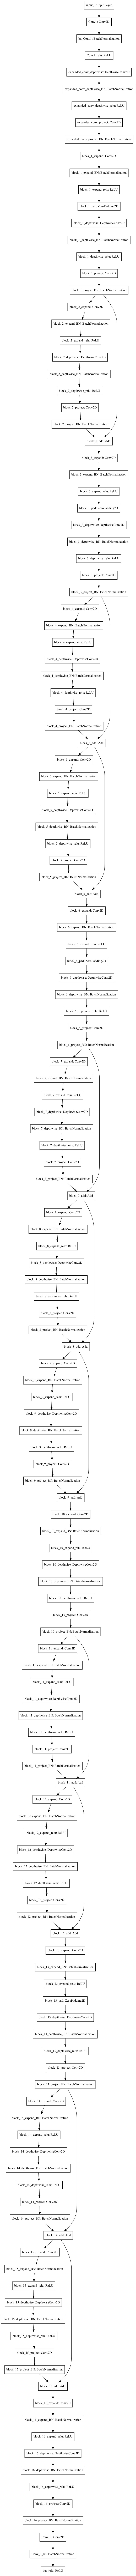

In [10]:
plot_model(backbone)

In [11]:
len(backbone.layers)

154

In [12]:
layer_names = [
    'block_1_expand_relu', # 64x64
    'block_3_expand_relu', # 32x32
    'block_6_expand_relu', # 16x16
    'block_13_expand_relu', # 8x8
    'block_16_project', # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

NameError: name 'base_model' is not defined